In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
import json
from keras.preprocessing.text import tokenizer_from_json
from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import pad_sequences
import nltk
from tqdm.notebook import tqdm
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
ner = pd.read_csv('ner_dataset.csv',encoding='latin1')
ner = ner.drop('POS',axis=1)
ner['Sentence #'] = ner['Sentence #'].ffill()
ner.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O


## Essential info about entities:

- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [6]:
X_sent = ner.groupby('Sentence #').apply(lambda s: [(w,t) for w,t in zip(s['Word'].values,s['Tag'].values)])

In [7]:
max_len = 50
with open('tok.txt') as json_file:
    tok_data = json.load(json_file)

In [8]:
tok = tokenizer_from_json(tok_data)

In [9]:
len(tok.word_index)

30258

In [10]:
tags2index = {'B-art': 7,
 'B-eve': 2,
 'B-geo': 16,
 'B-gpe': 5,
 'B-nat': 15,
 'B-org': 12,
 'B-per': 1,
 'B-tim': 9,
 'I-art': 10,
 'I-eve': 11,
 'I-geo': 6,
 'I-gpe': 3,
 'I-nat': 4,
 'I-org': 14,
 'I-per': 8,
 'I-tim': 13,
 'O': 0}

In [11]:

y = [[tags2index[w[1]] for w in s] for s in X_sent]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])
y[15]

array([5, 0, 0, 1, 8, 8, 8, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [12]:
X = [[str(w[0]) for w in s] for s in X_sent]
np.array(X[0])

array(['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through',
       'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and',
       'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from',
       'that', 'country', '.'], dtype='<U13')

In [13]:

X_pos = [[[w[1]] for w in nltk.pos_tag(i)] for i in tqdm(X)]

In [14]:
unique_pos = []
for i in X_pos:
    for j in i:
        if (j[0] not in unique_pos):
            unique_pos.append(j[0])

unique_pos.sort()


In [15]:
pos2index = {t:i+1 for i,t in enumerate(unique_pos)}#No need for 0..0 fr padding

In [16]:
X_pos  = [[pos2index[w[1]] for w in nltk.pos_tag(i)] for i in tqdm(X)]

In [17]:
X_seq = tok.texts_to_sequences(X)
X_padded = pad_sequences(maxlen=max_len,sequences=X_seq,padding="post")
X_padded[0]

array([ 260,    5,  992,   16, 1751,  227,  473,    6,  522,    1,  129,
          4,   60,    8,  574,    1,  876,    5,  187,   90,   21,   14,
         55,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [18]:
X_pos_padded = pad_sequences(maxlen=max_len,sequences = X_pos,padding="post")

In [19]:
X_pos_padded[0]

array([22, 14, 22, 38, 37, 14, 20, 32, 34, 11, 19, 14, 20,  9, 34, 11, 19,
       14, 15, 22, 14, 11, 19,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X_padded,y,test_size=0.20,random_state = 77)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.15,random_state = 77)
X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape

((32611, 50), (32611, 50), (5756, 50), (5756, 50), (9592, 50), (9592, 50))

In [21]:
X_train_pos,X_test_pos= train_test_split(X_pos_padded,test_size=0.20,random_state = 77)
X_train_pos,X_val_pos= train_test_split(X_train_pos,test_size = 0.15,random_state = 77)
X_train_pos.shape,X_val_pos.shape,X_test_pos.shape

((32611, 50), (5756, 50), (9592, 50))

## Model

In [22]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip

In [23]:
#%%capture
#!unzip glove.6B.zip

In [24]:
embeddings_index = {}
import os
f = open(os.path.join('', 'glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [25]:
EMBEDDING_DIM = 300
word_index = tok.word_index
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [26]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=50,
                            trainable=False)

In [27]:
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda,Flatten,concatenate

In [28]:
main_input = Input(shape=(50,),name = 'main_input')

emb = embedding_layer(main_input)
l1 = Bidirectional(LSTM(256,return_sequences=True,recurrent_dropout=0.2,dropout=0.2))(emb)
l2 = Bidirectional(LSTM(256,return_sequences=True,recurrent_dropout=0.2,dropout=0.2))(l1)
x = add([l1,l2])


In [29]:
aux_input = Input(shape=(50,),name = 'aux_input')
emb_pos = Embedding(output_dim=43,input_length=50,input_dim = 43)(aux_input)
l3 = Bidirectional(LSTM(256,return_sequences=True,recurrent_dropout=0.2,dropout=0.2))(emb_pos)
l4 = Bidirectional(LSTM(256,return_sequences=True,recurrent_dropout=0.2,dropout=0.2))(l3)
x2 = add([l3,l4])





In [30]:
conc = concatenate([x, x2])
d1 = TimeDistributed(Dense(256,activation="relu"))(conc)
out = TimeDistributed(Dense(len(tags2index),activation="softmax"))(d1)
model = Model([main_input,aux_input],out)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 50)           0                                            
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      9077700     main_input[0][0]                 
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 43)       1849        aux_input[0][0]                  
____________________________________________________________________________________________

In [138]:
from keras import optimizers as op
model.compile(loss='sparse_categorical_crossentropy',optimizer=op.Adam(lr=1e-3),metrics=['acc'])

In [139]:
y_train_t = y_train.reshape(y_train.shape[0],y_train.shape[1],1)
y_val_t = y_val.reshape(y_val.shape[0],y_val.shape[1],1)

In [140]:
model.fit([np.array(X_train),np.array(X_train_pos)],y_train_t,batch_size=256,epochs=5,
          validation_data=([np.array(X_val),np.array(X_val_pos)],y_val_t),)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 32611 samples, validate on 5756 samples
Epoch 1/5
32611/32611 [==============================] - 86s 3ms/step - loss: 0.2488 - acc: 0.9472 - val_loss: 0.0793 - val_acc: 0.9783
Epoch 2/5
32611/32611 [==============================] - 80s 2ms/step - loss: 0.0707 - acc: 0.9796 - val_loss: 0.0608 - val_acc: 0.9821
Epoch 3/5
32611/32611 [==============================] - 80s 2ms/step - loss: 0.0596 - acc: 0.9821 - val_loss: 0.0544 - val_acc: 0.9837
Epoch 4/5
32611/32611 [==============================] - 80s 2ms/step - loss: 0.0538 - acc: 0.9836 - val_loss: 0.0514 - val_acc: 0.9843
Epoch 5/5
32611/32611 [==============================] - 80s 2ms/step - loss: 0.0497 - acc: 0.9845 - val_loss: 0.0482 - val_acc: 0.9852


In [141]:
model.fit([np.array(X_train),np.array(X_train_pos)],y_train_t,batch_size=256,epochs=5,
          validation_data=([np.array(X_val),np.array(X_val_pos)],y_val_t),)

Train on 32611 samples, validate on 5756 samples
Epoch 1/5
32611/32611 [==============================] - 80s 2ms/step - loss: 0.0466 - acc: 0.9855 - val_loss: 0.0475 - val_acc: 0.9855
Epoch 2/5
32611/32611 [==============================] - 79s 2ms/step - loss: 0.0439 - acc: 0.9861 - val_loss: 0.0451 - val_acc: 0.9861
Epoch 3/5
32611/32611 [==============================] - 78s 2ms/step - loss: 0.0414 - acc: 0.9867 - val_loss: 0.0446 - val_acc: 0.9862
Epoch 4/5
32611/32611 [==============================] - 77s 2ms/step - loss: 0.0394 - acc: 0.9872 - val_loss: 0.0445 - val_acc: 0.9863
Epoch 5/5
32611/32611 [==============================] - 77s 2ms/step - loss: 0.0375 - acc: 0.9877 - val_loss: 0.0451 - val_acc: 0.9859


In [142]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=op.Adam(lr=5e-4),metrics=['acc'])
model.fit([np.array(X_train),np.array(X_train_pos)],y_train_t,batch_size=256,epochs=15,
          validation_data=([np.array(X_val),np.array(X_val_pos)],y_val_t),)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 32611 samples, validate on 5756 samples
Epoch 1/15
32611/32611 [==============================] - 101s 3ms/step - loss: 0.0345 - acc: 0.9886 - val_loss: 0.0435 - val_acc: 0.9865
Epoch 2/15
32611/32611 [==============================] - 95s 3ms/step - loss: 0.0329 - acc: 0.9891 - val_loss: 0.0441 - val_acc: 0.9865
Epoch 3/15
32611/32611 [==============================] - 95s 3ms/step - loss: 0.0317 - acc: 0.9895 - val_loss: 0.0443 - val_acc: 0.9864
Epoch 4/15
32611/32611 [==============================] - 95s 3ms/step - loss: 0.0306 - acc: 0.9898 - val_loss: 0.0433 - val_acc: 0.9866
Epoch 5/15
32611/32611 [==============================] - 95s 3ms/step - loss: 0.0293 - acc: 0.9901 - val_loss: 0.0444 - val_acc: 0.9865
Epoch 6/15
32611/32611 [==============================] - 95s 3ms/step - loss: 0.0283 - acc: 0.9903 - val_loss: 0.0443 - val_acc: 0.9868
Epoch 7/15
32611/32611 [==============================] - 95s 3ms/step - loss: 0.0270 - acc: 0.9908 - val_loss: 0.0450 - val_acc

In [370]:
model.save('Seq_pos_256.h5')

In [31]:
model.load_weights('Seq_pos_256.h5')

In [148]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report


In [35]:
idx2tag = {i: w for w, i in tags2index.items()}

def pred2label(pred):
  out = [] 
  for pred_i in test_pred:
    out_i = []
    for p in pred_i:
      p_i = np.argmax(p)
      out_i.append(idx2tag[p_i])
    out.append(out_i)
  return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p])
        out.append(out_i)
    return out

In [143]:
test_pred = model.predict([X_test,X_test_pos],verbose=1)

9592/9592 [==============================] - 25s 3ms/step


In [149]:
y_pt = pred2label(test_pred)
y_tt = test2label(y_test)
print(classification_report(y_tt, y_pt))

           precision    recall  f1-score   support

      geo       0.86      0.88      0.87      7624
      tim       0.85      0.84      0.85      4107
      per       0.74      0.78      0.76      3309
      org       0.67      0.67      0.67      3958
      gpe       0.93      0.94      0.93      3173
      nat       0.50      0.44      0.47        41
      art       0.09      0.06      0.07        82
      eve       0.43      0.40      0.41        58

micro avg       0.81      0.83      0.82     22352
macro avg       0.81      0.83      0.82     22352



In [150]:
model.save('f1_0_82.h5')

In [32]:
from nltk.tokenize import word_tokenize

In [335]:
text ='
words = word_tokenize(text)

t_seq = []
for i in tok.texts_to_sequences(words):
    try:
        t_seq.append(i[0])
    except:
        t_seq.append(0)
print(t_seq)

t_pos = [pos2index[w[1]] for w in nltk.pos_tag(words)]

t_seq_padded = np.array(pad_sequences(maxlen=max_len,sequences = [t_seq],padding="post")).reshape(1,50)
t_pos_padded = np.array(pad_sequences(maxlen=max_len,sequences = [t_pos],padding="post")).reshape(1,50)


pred = model.predict([t_seq_padded,t_pos_padded])

p = np.argmax(pred, axis=-1)[0]
print("{:15} : {}".format("Word", "Pred"))
print("="*30)

for j in range(len(words)):
    print("{:15} :  {}".format(words[j],idx2tag[p[j]]))

[0, 13, 606, 10, 0, 0, 2]
Word            : Pred
Karthik         :  B-per
is              :  O
working         :  O
for             :  O
Infosys         :  B-org
Ltd             :  I-org
.               :  O


In [33]:
def predict_on_text(text):
    words = word_tokenize(text)

    t_seq = []
    for i in tok.texts_to_sequences(words):
        try:
            t_seq.append(i[0])
        except:
            t_seq.append(0)

    t_pos = [pos2index[w[1]] for w in nltk.pos_tag(words)]

    t_seq_padded = np.array(pad_sequences(maxlen=max_len,sequences = [t_seq],padding="post")).reshape(1,50)
    t_pos_padded = np.array(pad_sequences(maxlen=max_len,sequences = [t_pos],padding="post")).reshape(1,50)


    pred = model.predict([t_seq_padded,t_pos_padded])

    p = np.argmax(pred, axis=-1)[0]
    print("{:15} : {}".format("Word", "Pred"))
    print("="*30)

    for j in range(len(words)):
        print("{:15} :  {}".format(words[j],idx2tag[p[j]]))

In [376]:
predict_on_text('Karthick went to Mumbai')

Word            : Pred
Karthick        :  B-per
went            :  O
to              :  O
Mumbai          :  B-geo


In [285]:
predict_on_text('Kanimozhi went to Mumbai from Chennai Railway Station yesterday night.')

Word            : Pred
Kanimozhi       :  B-per
went            :  O
to              :  O
Mumbai          :  B-geo
from            :  O
Chennai         :  B-geo
Railway         :  I-geo
Station         :  I-geo
yesterday       :  B-tim
night           :  I-tim
.               :  O


In [368]:
predict_on_text('India won in the Commonwealth Games')

Word            : Pred
India           :  B-geo
won             :  O
in              :  O
the             :  O
Commonwealth    :  B-eve
Games           :  I-eve


In [378]:
predict_on_text("Aakash is working for Infosys Ltd.")

Word            : Pred
Aakash          :  B-per
is              :  O
working         :  O
for             :  O
Infosys         :  B-org
Ltd             :  I-org
.               :  O


In [382]:
predict_on_text("Kamal went to Ibaco yesterday to eat ice cream")

Word            : Pred
Kamal           :  B-per
went            :  O
to              :  O
Ibaco           :  B-geo
yesterday       :  B-tim
to              :  O
eat             :  O
ice             :  O
cream           :  O


In [38]:
from keras.utils import plot_model

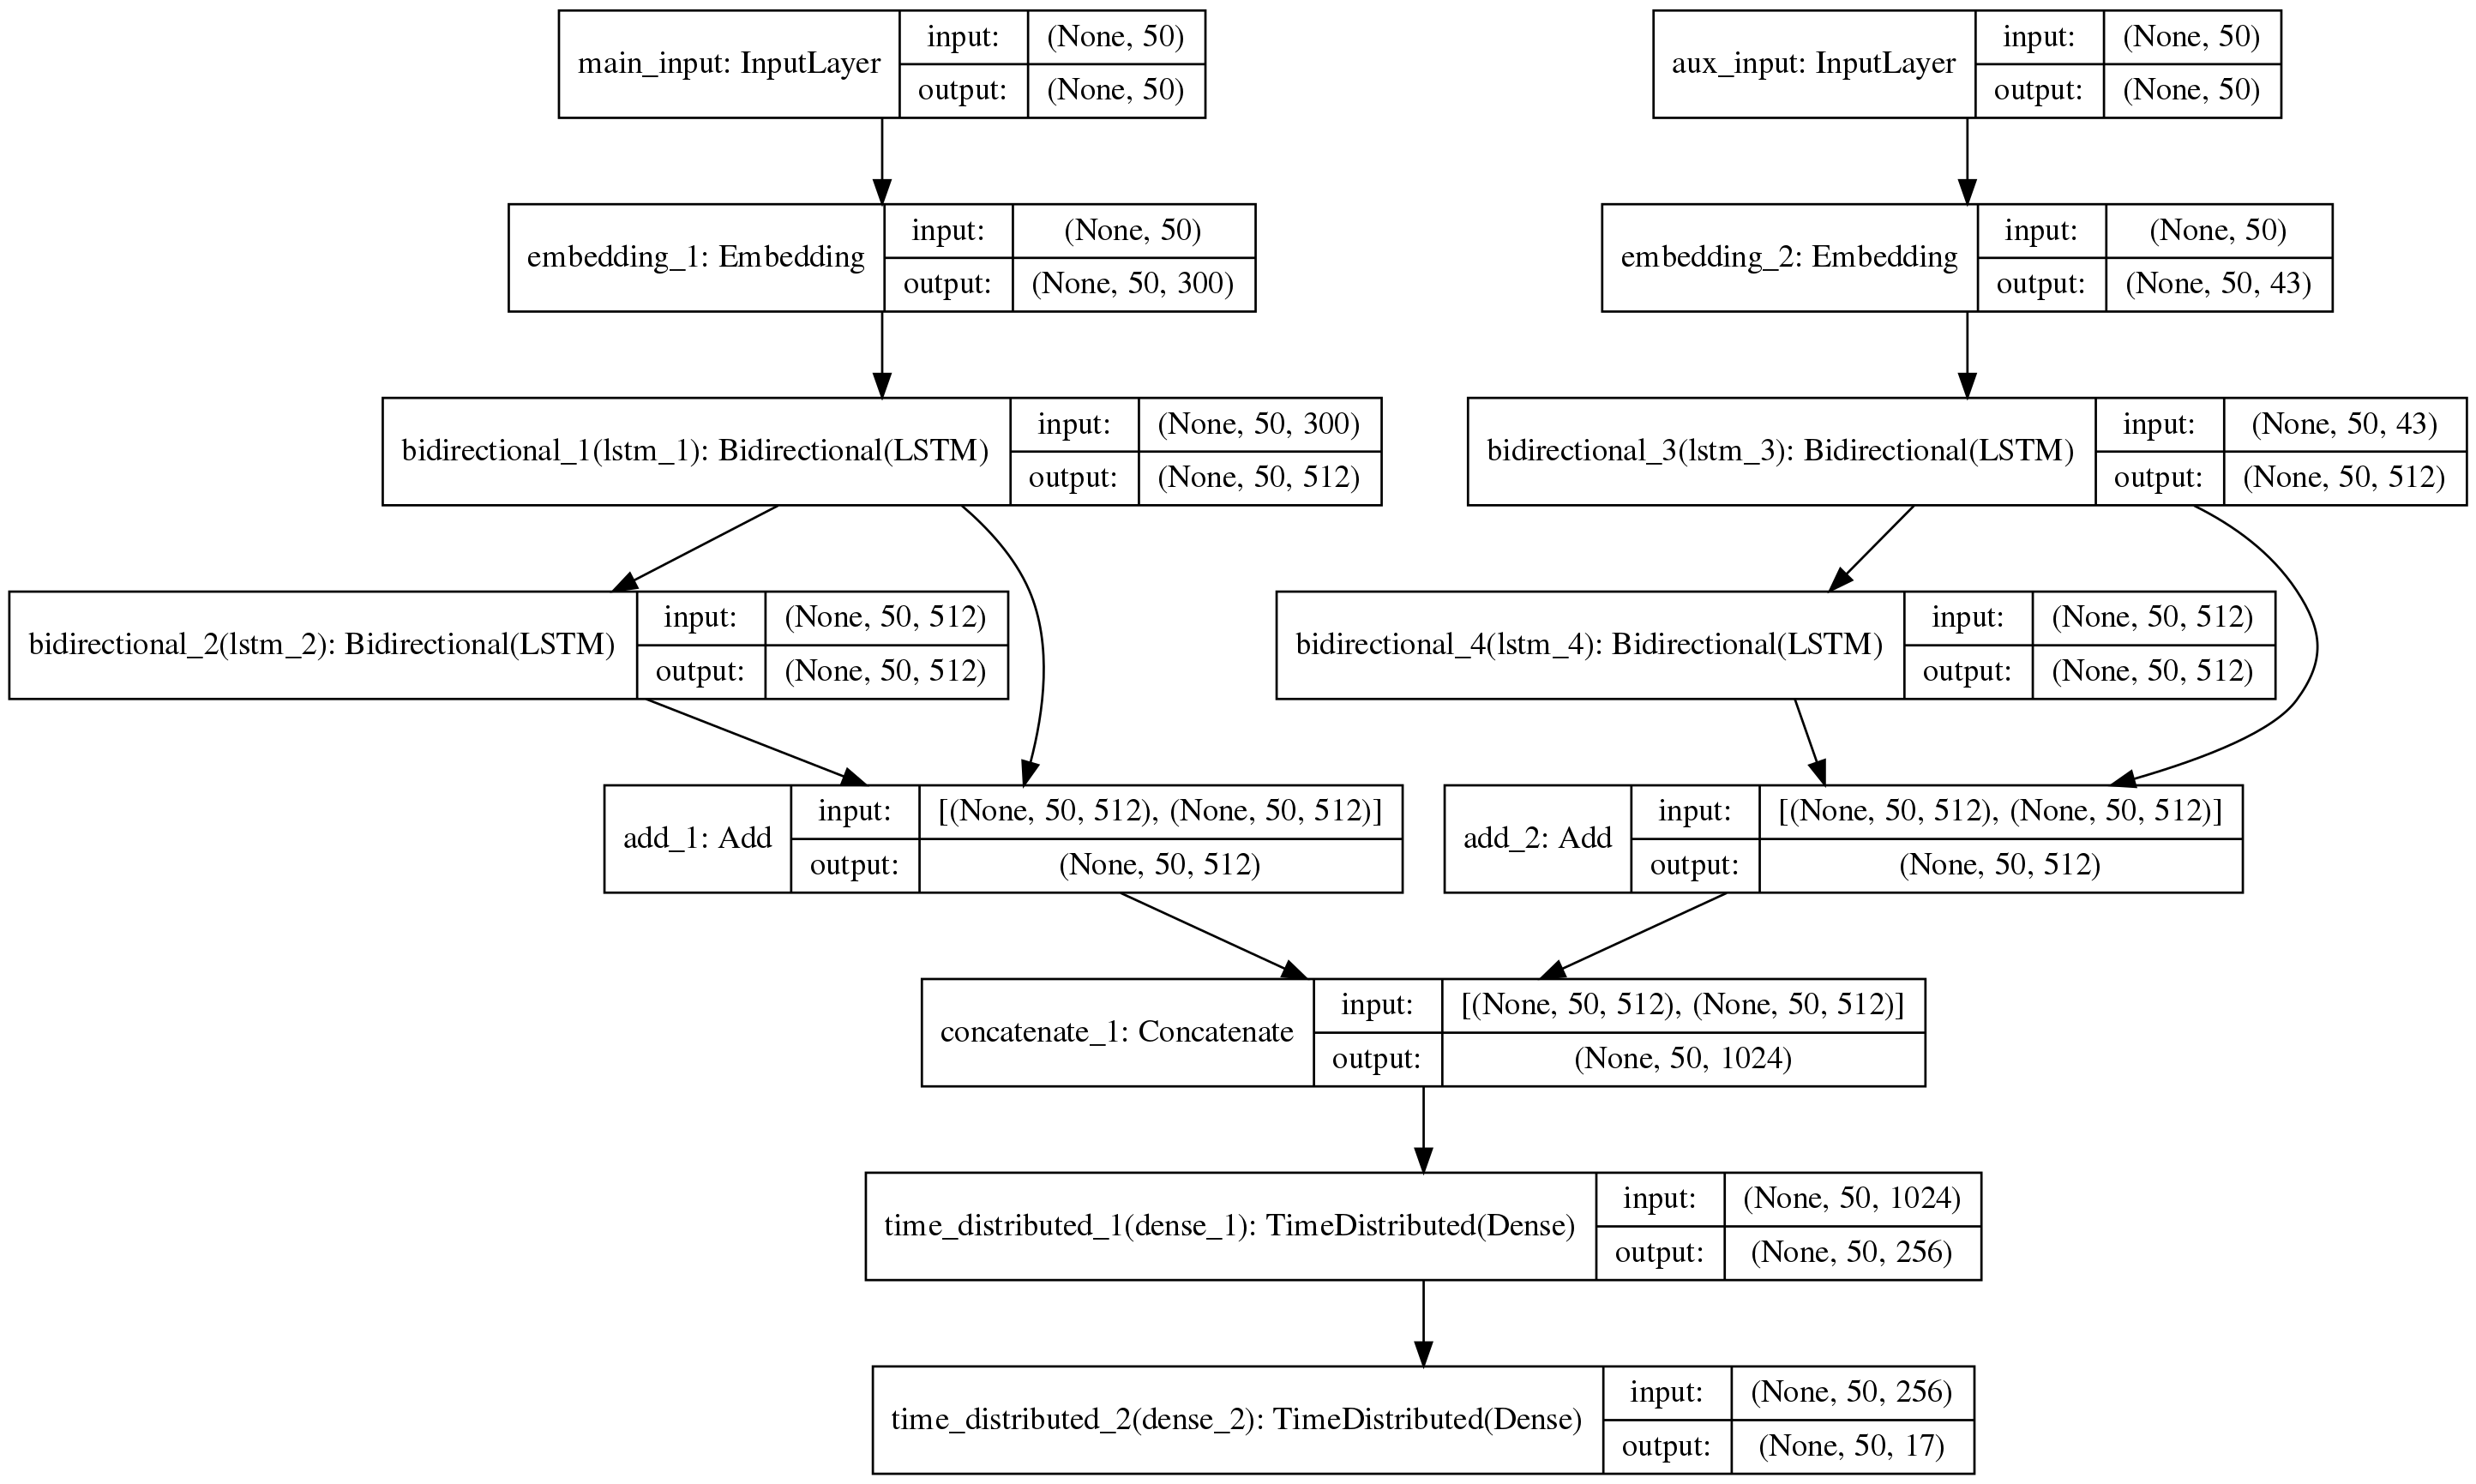

In [39]:
plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=196,
)